# M1 Applied Data Science - Coursework Submission
### Steven Dillmann

**MPhil Data Intensive Science | University of Cambridge**

20th December 2023

[sd2022@cam.ac.uk](sd2022@cam.ac.uk)

This notebook was written by Steven Dillmann as part of the coursework submission for the M1 Applied Data Science module in the MPhil in Data Intensive Science at the University of Cambridge. The coursework assignment can be found here: [M1 Applied Data Science - Coursework Assignment](../DIS_MPhil_M1_Coursework.pdf).

In [1]:
!pip install pandas
!pip install seaborn
!pip install scikit-learn
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install tabulate  

In [2]:
# Import required libraries
import pandas as pd
import warnings
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from tabulate import tabulate
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", message="Some inputs do not have OOB scores.*")

# Set up matplotlib style and colours
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.style.use('sd2022.mplstyle')
import seaborn as sns
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.family'] = 'DejaVu Sans'
sd2022_blue = '#3772ff'
sd2022_red = '#FF033E'
sd2022_green = '#05a45c'
sd2022_purple = '#994d9e' # DIS logo colour
sd2022_orange = '#ff8243'
sd2022_gold = '#cfbd62' 
sd2022_silver = '#C0C0C0'
color_dict = {'red':   [(0.0, 1.0, 1.0), (1.0, 1.0, 1.0)],
              'green': [(0.0, 0.0, 0.0), (1.0, 0.0, 0.0)],
              'blue':  [(0.0, 0.0, 0.0), (1.0, 0.0, 0.0)]}
cmap_blue = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',sd2022_blue], N=256)
cmap_red = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',sd2022_red], N=256)
cmap_green = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',sd2022_green], N=256)
cmap_orange = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',sd2022_orange], N=256)

# Set up some random seeds
seed_dob = 260699
seed_fave_song = 505
seed_football_number = 11
seed_love = 711
seed_year = 2023

## Question 4 - Baseline Dataset: Supervised Learning and Random Forests

In [3]:
# Load dataset D into a dataframe
file_path = '../data/ADS_baselineDataset.csv'
df = pd.read_csv(file_path,index_col=0)

(b) Pre-process and filter the data in preparation for the classifier. In your report, explain how you have pre-processed the data and justify any steps you have taken.


In [4]:
# === Pre-processing analysis ======================================================================

print("PRE-PROCESSING ANALYSIS: \n")
      
# === Check the shape of the dataset ===============================================================

# Display the shape of the dataset
print("Dataset shape:", df.shape)
print("Number of observations:", df.shape[0])
print("Number of features:", df.drop('type', axis=1).shape[1])

# === Check Label frequencies ======================================================================

# Get the absolute and relative frequency of labels ('type' column)
df_class_counts = df['type'].value_counts(dropna=False).reset_index()
df_class_counts['relative_count'] = (df_class_counts['count'] / len(df)).round(3)

# Display label frequencies using tabulate
print("Label frequencies:\n")
print(tabulate(df_class_counts, headers = ['Label', 'Frequency', 'Relative Frequency'], showindex=False))

# Get indices of rows where 'type' is missing
rows_missing_type = df[df['type'].isnull()].index.to_list()
print("Number of observations with missing 'type':", len(rows_missing_type))

# === Check for duplicate observations =============================================================

# Extract the feature columns and get duplicates
feature_columns = df.columns[df.columns != 'type'].tolist()
duplicates = df[df.duplicated(subset=feature_columns)]
print("Number of duplicate observations: ", len(duplicates))

# === Check for missing values =====================================================================

# Get features with missing values
features_with_missing = df.columns[df.isnull().any()].tolist()
print("Number of features with missing values: ", len(features_with_missing))

# === Check for non-numeric features ===============================================================

# Get non-numeric features
non_numeric_features = df.select_dtypes(exclude=np.number).columns.tolist()
print("Number of non-numeric features: ", len(non_numeric_features))

# === Check for highly correlated features ==========================================================

# Calculate correlation matrix
correlation_matrix = df.corr().abs()

# Create a mask to ignore correlations with oneself
mask = ~pd.DataFrame(np.eye(correlation_matrix.shape[0], dtype=bool), index=correlation_matrix.index, columns=correlation_matrix.columns)

# Get highly correlated features (correlation > 0.9)
highly_correlated = correlation_matrix[mask].stack().reset_index()
highly_correlated = highly_correlated[highly_correlated[0] > 0.9] 

# Remove duplicates to get unique pairs of highly correlated features
highly_correlated['sorted_pair'] = highly_correlated.apply(lambda row: sorted([row['level_0'], row['level_1']]), axis=1)
highly_correlated_pairs = highly_correlated['sorted_pair'].drop_duplicates()
highly_correlated_to_drop = []
for pair in highly_correlated_pairs:
    highly_correlated_to_drop.append(pair[1])
print("Number of highly correlated features (correlation > 0.90): ", len(highly_correlated_to_drop))

# === Check near-zero variance features ============================================================

# Get features with near-zero variance
variances = df.var()
threshold = 0.01
near_zero_var_features = variances[variances <= threshold].index.tolist()
print("Number of near-zero variance features: ", len(near_zero_var_features))

# Get features with only one unique value
features_no_variance = df.columns[df.nunique() == 1].tolist()
print("...of which are features with only one unique value: ", len(features_no_variance))

# Get colmns with all values being zero
zero_features = df.columns[(df == 0).all()].tolist()
print("...of which are features with all values being zero: ", len(zero_features))

# === Outlier detection ============================================================================

# Detect outliers in the original data using a custom IQR method (Tukey's fences)
def detect_outliers_iqr(df,  threshold=3):
    """Detect outliers using the IQR method (Tukey's fences).

    Args:
        df (pd.DataFrame): Input dataframe.
        threshold (int, optional): Threshold for outlier detection. Defaults to 3.

    Returns:
        total_outliers (int): Total number of outlier values.
        num_rows_affected (int): Number of rows affected by outliers.
        num_features_affected (int): Number of features affected by outliers.
        outliers (pd.DataFrame): Boolean dataframe indicating outliers.
    """
    # Initialise RobustScaler
    scaler = RobustScaler()
    # Scale the data using RobustScaler
    X_robust = scaler.fit_transform(df)
    df_robust = pd.DataFrame(X_robust, columns=df.columns, index=df.index)
    # Calculate the custom IQR 
    Q1 = df_robust.quantile(0.25)
    Q3 = df_robust.quantile(0.75)
    IQR = Q3 - Q1
    # Detect outliers using the IQR method
    outliers = ((df_robust < (Q1 - threshold * IQR)) | (df_robust > (Q3 +  threshold * IQR)))
    # Calculate the number of total outlier values
    total_outliers = outliers.sum().sum()
    # Calculate the number of rows affected by outliers
    affected_rows = df_robust[outliers.any(axis=1)].index.tolist()
    num_rows_affected = len(affected_rows)
    # Calculate the number of features affected by outliers
    affected_features = df_robust.columns[outliers.any(axis=0)].tolist()
    num_features_affected = len(affected_features)
    return total_outliers, num_rows_affected, num_features_affected, outliers

total_outliers, num_rows_affected, num_features_affected,_ = detect_outliers_iqr(df.drop('type', axis=1))

# Display outlier detection results
print(f"Total number of outliers: {total_outliers}")
print(f"Number of features affected by outliers: {num_features_affected}")
print(f"Number of observations affected by outliers: {num_rows_affected}")

PRE-PROCESSING ANALYSIS: 

Dataset shape: (500, 1001)
Number of observations: 500
Number of features: 1000
Label frequencies:

  Label    Frequency    Relative Frequency
-------  -----------  --------------------
      1          190                 0.38
      2          178                 0.356
      3          132                 0.264
Number of observations with missing 'type': 0
Number of duplicate observations:  0
Number of features with missing values:  0
Number of non-numeric features:  0
Number of highly correlated features (correlation > 0.90):  4
Number of near-zero variance features:  185
...of which are features with only one unique value:  42
...of which are features with all values being zero:  42
Total number of outliers: 14182
Number of features affected by outliers: 700
Number of observations affected by outliers: 500


In [5]:
# === Apply pre-processing steps ===================================================================

print("PRE-PROCESSING STEPS:\n")

# Outlier correction using KNNImputer
print("Imputing outlier values using KNNImputer...")
def iterative_outlier_correction_knn(df, threshold=3, k=46, num_iterations=50):
    # Copy original dataframe
    df_original = df.copy()
    # Initialise outlier statistics lists
    total_outliers_list = []
    num_rows_affected_list = []
    num_features_affected_list = []
    # Loop over number of iterations
    for i in range(num_iterations):
        # Detect outliers
        total_outliers, num_rows_affected, num_features_affected, outliers = detect_outliers_iqr(df, threshold)
        # Store outlier statistics
        total_outliers_list.append(total_outliers)
        num_rows_affected_list.append(num_rows_affected)
        num_features_affected_list.append(num_features_affected)
        # Replace outliers with NaN only in the original data
        df_original[outliers] = np.nan
        # Impute NaN values using KNNImputer
        imputer = KNNImputer(n_neighbors=k)
        df_updated = pd.DataFrame(imputer.fit_transform(df_original), columns=df_original.columns, index=df_original.index)
        # Update the data DataFrame with imputed values only for original outliers
        df[outliers] = np.where(outliers, df_updated, df)
        # Check if there are any outliers left
        if total_outliers == 0:
            print(f"Converged to no outliers after {i+1} iterations.")
            break
    return df, total_outliers_list, num_rows_affected_list, num_features_affected_list

# Impute outlier values using KNNImputer
df_outliers = df.drop('type', axis=1).copy()
df_corrected, total_outliers_list, num_rows_affected_list, num_features_affected_list = iterative_outlier_correction_knn(df_outliers, k=46, num_iterations=50)

# Check final corrected data for outliers
total_outliers_final, num_rows_affected_final, num_features_affected_final, _ = detect_outliers_iqr(df_corrected)

# Display final outlier statistics
print(f"Total number of outliers after correction: {total_outliers_final}")
print(f"Number of features affected by outliers after correction: {num_features_affected_final}")
print(f"Number of observations affected by outliers after correction: {num_rows_affected_final}\n")


# Check for near-zero variance features after outlier correction
variances_corrected = df_corrected.var()
threshold = 0.01
near_zero_var_features_corrected = variances_corrected[variances_corrected <= threshold].index.tolist()
features_no_variance_corrected = df_corrected.columns[df_corrected.nunique() == 1].tolist()
zero_features_corrected = df_corrected.columns[(df_corrected == 0).all()].tolist()
print("Number of near-zero variance features (after outlier correction): ", len(near_zero_var_features_corrected))
print("...of which are features with only one unique value (after outlier correction): ", len(features_no_variance_corrected))
print("...of which are features with all values being zero (after outlier correction): ", len(zero_features_corrected))

# Drop near-zero, zero-variance and zero-inflated features
print("\nDropping zero-variance features...")
df_final = df_corrected.drop(near_zero_var_features_corrected, axis=1)
df_final['type'] = df['type']

# Check for near-zero variance features again
variances_final = df_final.var()
threshold = 0.01
near_zero_var_features_final = variances_final[variances_final <= threshold].index.tolist()
features_no_variance_final = df_final.columns[df_final.nunique() == 1].tolist()
zero_features_final = df_final.columns[(df_final == 0).all()].tolist()
print("Number of near-zero variance features (final): ", len(near_zero_var_features_final))
print("...of which are features with only one unique value (final): ", len(features_no_variance_final))
print("...of which are features with all values being zero (final): ", len(zero_features_final))

# Check for highly correlated features again (correlation > 0.95)
print("\nCheck if there are any highly correlated features (correlation > 0.90) left after dropping near-zero variance features...")
correlation_matrix_final = df_final.corr().abs()
mask_final = ~pd.DataFrame(np.eye(correlation_matrix_final.shape[0], dtype=bool), index=correlation_matrix_final.index, columns=correlation_matrix_final.columns)
highly_correlated_final = correlation_matrix_final[mask_final].stack().reset_index()
highly_correlated_final = highly_correlated_final[highly_correlated_final[0] > 0.9]
highly_correlated_final['sorted_pair'] = highly_correlated_final.apply(lambda row: sorted([row['level_0'], row['level_1']]), axis=1)
highly_correlated_pairs_final = highly_correlated_final['sorted_pair'].drop_duplicates()
highly_correlated_to_drop_final = []
for pair in highly_correlated_pairs_final:
    highly_correlated_to_drop_final.append(pair[1])
print("Number of highly correlated features (correlation > 0.90) (final): ", len(highly_correlated_to_drop_final))

# Final shape of the dataset
print("\nFinal data shape:", df_final.shape)
print("Number of observations:", df_final.shape[0])
print("Number of features:", df_final.drop('type', axis=1).shape[1])

# Save pre-processed dataset
print("\nSaving pre-processed dataset...")
print("Saved to ../data/ADS_baselineDataset_preprocessed.csv")
df_final.to_csv('../data/ADS_baselineDataset_preprocessed.csv')


PRE-PROCESSING STEPS:

Imputing outlier values using KNNImputer...
Converged to no outliers after 6 iterations.
Total number of outliers after correction: 0
Number of features affected by outliers after correction: 0
Number of observations affected by outliers after correction: 0

Number of near-zero variance features (after outlier correction):  688
...of which are features with only one unique value (after outlier correction):  688
...of which are features with all values being zero (after outlier correction):  688

Dropping zero-variance features...
Number of near-zero variance features (final):  0
...of which are features with only one unique value (final):  0
...of which are features with all values being zero (final):  0

Check if there are any highly correlated features (correlation > 0.90) left after dropping near-zero variance features...
Number of highly correlated features (correlation > 0.90) (final):  0

Final data shape: (500, 313)
Number of observations: 500
Number of fe

In [6]:
# === Data splitting ===============================================================================

X = df_final.drop('type', axis=1)
y = df_final['type']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed_dob, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed_dob, stratify=y_temp)
X_train_full = pd.concat([X_train, X_val], axis=0, ignore_index=True)
y_train_full = pd.concat([y_train, y_val], axis=0, ignore_index=True)

(c) Apply the classifier on training data using the default hyperparameters and summarise the output of the model. Evaluate the test set classification error.

Random Forest Classifier (default parameters):

Model Accuracy:  0.9333333333333333
Classification Error:  0.06666666666666665
Classification Report:
              precision    recall  f1-score   support

           1       0.97      0.97      0.97        29
           2       0.93      0.96      0.94        26
           3       0.89      0.85      0.87        20

    accuracy                           0.93        75
   macro avg       0.93      0.93      0.93        75
weighted avg       0.93      0.93      0.93        75

Confusion Matrix:


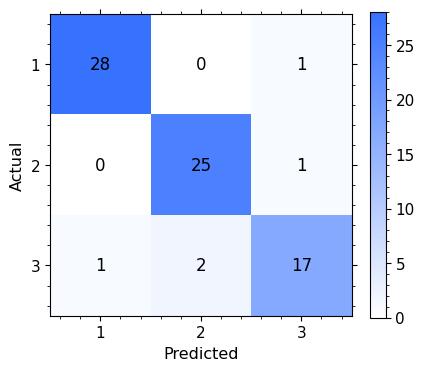

In [7]:
# === Random Forest Classifier (default parameters) ================================================

# Initialise Random Forest Classifier with default parameters
rf = RandomForestClassifier(random_state=seed_love)

# Train the model on training and validation data
rf.fit(X_train_full, y_train_full)

# Make predictions on test data
y_pred_rf_default = rf.predict(X_test)

# Evaluate the model on test data
def evaluate_model(y_test, y_pred):
    # Calculate the prediction accuracy 
    accuracy = accuracy_score(y_test, y_pred)
    # Calculate the classification error
    error = 1 - accuracy
    # Generate confusion matrix
    confusion_matrix_result = confusion_matrix(y_test, y_pred)
    # Generate classification report
    classification_report_result = classification_report(y_test, y_pred)
    return accuracy, error, confusion_matrix_result, classification_report_result

accuracy, error, confusion_matrix_result, classification_report_result = evaluate_model(y_test, y_pred_rf_default)

# Print results
print("Random Forest Classifier (default parameters):\n")
print("Model Accuracy: ", accuracy)
print("Classification Error: ", error)
print("Classification Report:")
print(classification_report_result)

# Plot confusion matrix
print("Confusion Matrix:")
plt.figure(figsize=(4.5, 4))
plt.imshow(confusion_matrix_result, interpolation='nearest', cmap=cmap_blue)
plt.colorbar(shrink=0.9)
custom_labels = [1, 2, 3]
tick_marks = np.arange(len(custom_labels))
plt.xticks(tick_marks, custom_labels)
plt.yticks(tick_marks, custom_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
# Add annotations
for i in range(len(confusion_matrix_result)):
    for j in range(len(confusion_matrix_result)):
        plt.text(j, i, str(confusion_matrix_result[i][j]), ha='center', va='center', color='black', fontsize=12)

(d) Optimise the algorithm with respect to the number of trees in the random forest. You should be able to do this without explicitly performing cross-validation.

Optimal number of trees: 221
Minimum OOB Error: 0.07058823529411762
Maximum OOB Accuracy: 0.9294117647058824


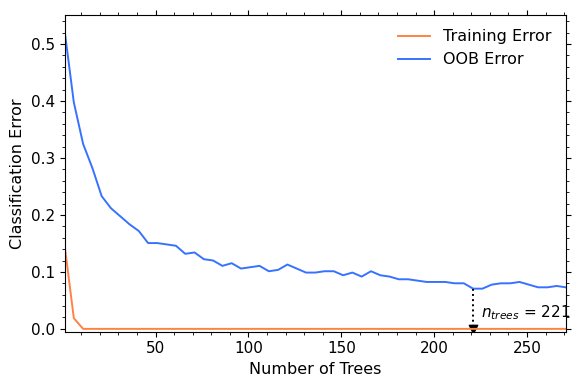

In [8]:
from sklearn.ensemble import RandomForestClassifier

# Define hyperparameter search space
n_trees_list = list(range(1, 276, 5))

# Define function to perform hyperparameter tuning
def hyperparameter_tuning_rf(X_train, y_train, n_trees_list, seed):
    # Initialise lists to store errors
    train_errors = []
    oob_errors = []
    # Loop over different number of trees
    for n_trees in n_trees_list:
        # Initialise Random Forest Classifier
        rf_classifier = RandomForestClassifier(n_estimators=n_trees, random_state=seed, oob_score=True)
        rf_classifier.fit(X_train, y_train)
        # Calculate training error
        train_pred = rf_classifier.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_pred)
        train_error = 1 - train_accuracy
        train_errors.append(train_error)
        # Calculate OOB error
        oob_error = 1 - rf_classifier.oob_score_
        oob_errors.append(oob_error)
    return train_errors, oob_errors

# Perform hyperparameter tuning
train_errors, oob_errors = hyperparameter_tuning_rf(X_train_full, y_train_full, n_trees_list, seed_love)

# Get the optimal number of trees and minimum OOB error
optimal_n_trees = n_trees_list[np.argmin(oob_errors)]
min_oob_error = min(oob_errors)
max_oob_accuracy = 1 - min_oob_error
print("Optimal number of trees:", optimal_n_trees)
print("Minimum OOB Error:", min_oob_error)
print("Maximum OOB Accuracy:", max_oob_accuracy)

# Plot training, validation, and OOB errors for different hyperparameter values
plt.figure()
plt.plot(n_trees_list, train_errors, linestyle='-', color=sd2022_orange, label='Training Error')
plt.plot(n_trees_list, oob_errors, linestyle='-', color=sd2022_blue, label='OOB Error')
plt.plot([optimal_n_trees, optimal_n_trees], [-0.005, min_oob_error], linestyle=':', color='black')
plt.scatter(optimal_n_trees, 0, marker='v', color='black')
plt.text(optimal_n_trees*1.02, 0.02, '$n_{trees}$ = ' + str(optimal_n_trees))
plt.xlabel('Number of Trees')
plt.ylabel('Classification Error')
plt.legend()
plt.ylim(bottom=-0.005)
plt.show()


Random Forest Classifier (optimal parameters):

Model Accuracy:  0.9466666666666667
Classification Error:  0.053333333333333344
Classification Report:
              precision    recall  f1-score   support

           1       0.93      0.97      0.95        29
           2       0.96      1.00      0.98        26
           3       0.94      0.85      0.89        20

    accuracy                           0.95        75
   macro avg       0.95      0.94      0.94        75
weighted avg       0.95      0.95      0.95        75

Confusion Matrix:


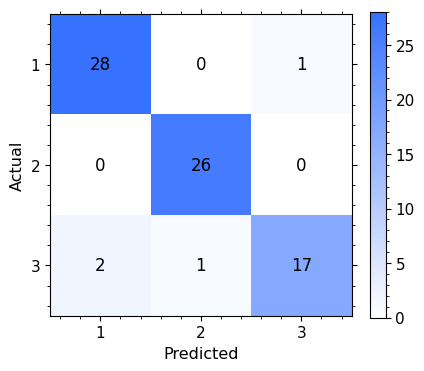

In [9]:
# === Random Forest Classifier (optimal parameters) ================================================

# Initialise Random Forest Classifier with optimal parameters
n_trees_optimal = 221
rf_opt = RandomForestClassifier(n_estimators=n_trees_optimal, random_state=seed_love)

# Train the model on training and validation data
rf_opt.fit(X_train_full, y_train_full)

# Make predictions on test data
y_pred_rf_opt = rf_opt.predict(X_test)

# Evaluate the model on test data
accuracy, error, confusion_matrix_result, classification_report_result = evaluate_model(y_test, y_pred_rf_opt)

# Print results
print("Random Forest Classifier (optimal parameters):\n")
print("Model Accuracy: ", accuracy)
print("Classification Error: ", error)
print("Classification Report:")
print(classification_report_result)

# Plot confusion matrix
print("Confusion Matrix:")
plt.figure(figsize=(4.5, 4))
plt.imshow(confusion_matrix_result, interpolation='nearest', cmap=cmap_blue)
plt.colorbar(shrink=0.9)
custom_labels = [1, 2, 3]
tick_marks = np.arange(len(custom_labels))
plt.xticks(tick_marks, custom_labels)
plt.yticks(tick_marks, custom_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
# Add annotations
for i in range(len(confusion_matrix_result)):
    for j in range(len(confusion_matrix_result)):
        plt.text(j, i, str(confusion_matrix_result[i][j]), ha='center', va='center', color='black', fontsize=12)

(e) Calculate the feature importance. In your report, describe and interpret the feature importances. Retrain the model using a subset of the most important features. In your report, indicate which features you have chosen and compare the retrained classifier with the original classifier.

In [10]:
def find_knee_point(cumulative, knee_criteria):
    # Calculate the relative change between consecutive values
    relative_change = np.diff(cumulative) / cumulative[:-1]
    # Find the knee point based on the relative change and knee criteria
    knee_point = np.argmax(relative_change <= knee_criteria) + 1
    return knee_point 

Top 37 features based on knee point criterion:
Feature Name      Feature Importance
--------------  --------------------
Fea64                     0.0631859
Fea70                     0.033953
Fea630                    0.0266599
Fea354                    0.0224076
Fea795                    0.0204325
Fea222                    0.0199395
Fea36                     0.0193132
Fea162                    0.0191289
Fea673                    0.0168101
Fea672                    0.0163653
Fea157                    0.0158996
Fea947                    0.0154774
Fea490                    0.0147097
Fea715                    0.0140217
Fea561                    0.0125133
Fea71                     0.0116286
Fea314                    0.0112232
Fea243                    0.0111965
Fea284                    0.0111867
Fea566                    0.00972724
Fea181                    0.00947807
Fea609                    0.00934071
Fea588                    0.00924769
Fea55                     0.00877374
Fea43      

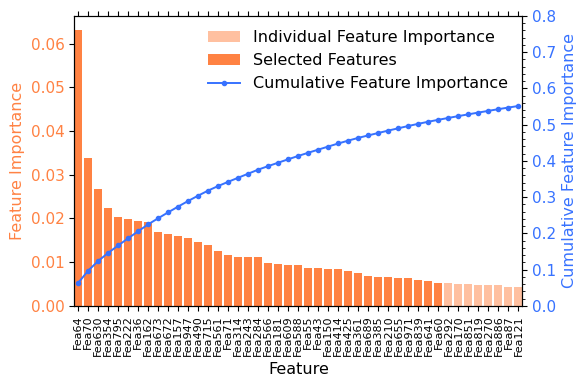

In [11]:
# === Random Forest Classifier Feature Importance ==================================================

# Get feature importances
feature_importances = rf_opt.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1][:45]
sorted_feature_importance = feature_importances[indices]
sorted_feature_names = X_train_full.columns[indices]
cumulative_importance = np.cumsum(sorted_feature_importance)

# Select the top features based on the knee point in the cumulative error curve
n_features_to_select = find_knee_point(cumulative_importance,knee_criteria=0.01)
top_feature_importance = sorted_feature_importance[:n_features_to_select]
top_feature_names = sorted_feature_names[:n_features_to_select]
top_features_headers = ["Feature Name", "Feature Importance"]
top_features_table = [[name, importance] for name, importance in zip(top_feature_names, top_feature_importance)]
print(f"Top {n_features_to_select} features based on knee point criterion:")
print(tabulate(top_features_table, headers=top_features_headers))

# Plot the feature importances of the forest
fig, ax1 = plt.subplots()
ax1.bar(range(len(sorted_feature_importance)), sorted_feature_importance, color=sd2022_orange, alpha = 0.5, label='Individual Feature Importance')
ax1.set_xlabel('Feature')
ax1.set_ylabel('Feature Importance', color=sd2022_orange)
ax1.tick_params(axis='y', labelcolor=sd2022_orange)
ax1.set_xticks(np.arange(len(sorted_feature_names)))
ax1.set_xticklabels(sorted_feature_names, rotation=90, fontsize=8)
ax1.minorticks_off()

# Plot the cumulative importances
ax2 = ax1.twinx()
ax2.plot(range(len(sorted_feature_importance)), cumulative_importance, color=sd2022_blue, marker='.', label='Cumulative Feature Importance')
ax2.set_ylabel('Cumulative Feature Importance', color=sd2022_blue)
ax2.tick_params(axis='y', labelcolor=sd2022_blue)
ax2.set_ylim(bottom=0.0, top=0.8)

# Plot the chosen number of components
ax1.bar(range(n_features_to_select), top_feature_importance[:n_features_to_select], color= sd2022_orange, label='Selected Features')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper right')

plt.show()

Optimal number of trees: 166
Minimum OOB Error: 0.07999999999999996
Maximum OOB Accuracy: 0.92


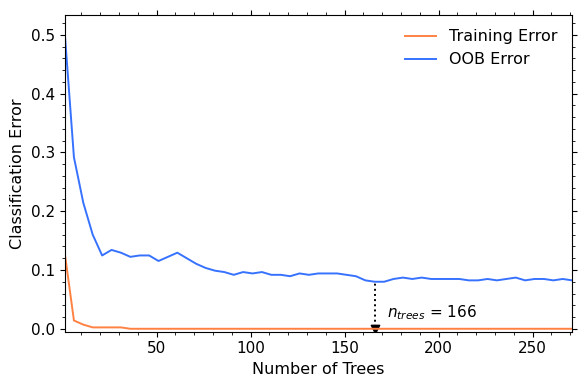

In [12]:
# === Random Forest Classifier Hyperparameter Tuning (most important features) =====================

# Get most important features
X_test_important = X_test[top_feature_names]
X_train_full_important = X_train_full[top_feature_names]

# Define hyperparameter search space
n_trees_list = list(range(1, 276, 5))

# Perform hyperparameter tuning
train_errors, oob_errors = hyperparameter_tuning_rf(X_train_full_important, y_train_full, n_trees_list, seed_love)

# Get the optimal number of trees and minimum validation error
optimal_n_trees = n_trees_list[np.argmin(oob_errors)]
min_oob_error = min(oob_errors)
max_oob_accuracy = 1 - min_oob_error
print("Optimal number of trees:", optimal_n_trees)
print("Minimum OOB Error:", min_oob_error)
print("Maximum OOB Accuracy:", max_oob_accuracy)

# Plot training and validation errors for different hyperparameter values
plt.figure()
plt.plot(n_trees_list, train_errors, linestyle='-', color=sd2022_orange, label='Training Error')
plt.plot(n_trees_list, oob_errors, linestyle='-', color=sd2022_blue, label='OOB Error')
plt.plot([optimal_n_trees, optimal_n_trees], [-0.005, min_oob_error], linestyle=':', color='black')
plt.scatter(optimal_n_trees, 0, marker='v', color='black')
plt.text(optimal_n_trees*1.04, 0.02, '$n_{trees}$ = ' + str(optimal_n_trees))
plt.xlabel('Number of Trees')
plt.ylabel('Classification Error')
plt.legend()
plt.ylim(bottom=-0.005)
plt.show()

Random Forest Classifier (most important features and optimal parameters):

Model Accuracy:  0.9466666666666667
Classification Error:  0.053333333333333344
Classification Report:
              precision    recall  f1-score   support

           1       0.97      0.97      0.97        29
           2       0.96      0.96      0.96        26
           3       0.90      0.90      0.90        20

    accuracy                           0.95        75
   macro avg       0.94      0.94      0.94        75
weighted avg       0.95      0.95      0.95        75

Confusion Matrix:


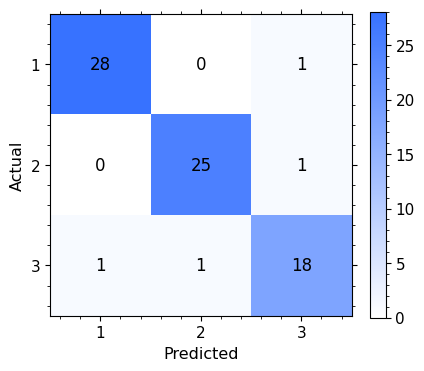

In [13]:
# === Random Forest Classifier (most important features and optimal parameters) ====================

# Initialise Random Forest Classifier with optimal parameters
n_trees_optimal = 166
rf_imp = RandomForestClassifier(n_estimators=n_trees_optimal, random_state=seed_fave_song)

# Train the model on training and validation data
rf_imp.fit(X_train_full_important, y_train_full)

# Make predictions on test data
y_pred_rf_imp = rf_imp.predict(X_test_important)

# Evaluate the model on test data
accuracy, error, confusion_matrix_result, classification_report_result = evaluate_model(y_test, y_pred_rf_imp)

# Print results
print("Random Forest Classifier (most important features and optimal parameters):\n")
print("Model Accuracy: ", accuracy)
print("Classification Error: ", error)
print("Classification Report:")
print(classification_report_result)

# Plot confusion matrix
print("Confusion Matrix:")
plt.figure(figsize=(4.5, 4))
plt.imshow(confusion_matrix_result, interpolation='nearest', cmap=cmap_blue)
plt.colorbar(shrink=0.9)
custom_labels = [1, 2, 3]
tick_marks = np.arange(len(custom_labels))
plt.xticks(tick_marks, custom_labels)
plt.yticks(tick_marks, custom_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
# Add annotations
for i in range(len(confusion_matrix_result)):
    for j in range(len(confusion_matrix_result)):
        plt.text(j, i, str(confusion_matrix_result[i][j]), ha='center', va='center', color='black', fontsize=12)

(f) Repeat steps (b),(c) and (e) for one other supervised learning classifier. Compare and contrast the two classification approaches and your results for each.


AdaBoost Classifier (default parameters):

Model Accuracy:  0.8933333333333333
Classification Error:  0.10666666666666669
Classification Report:
              precision    recall  f1-score   support

           1       0.87      0.90      0.88        29
           2       0.92      0.92      0.92        26
           3       0.89      0.85      0.87        20

    accuracy                           0.89        75
   macro avg       0.89      0.89      0.89        75
weighted avg       0.89      0.89      0.89        75

Confusion Matrix:


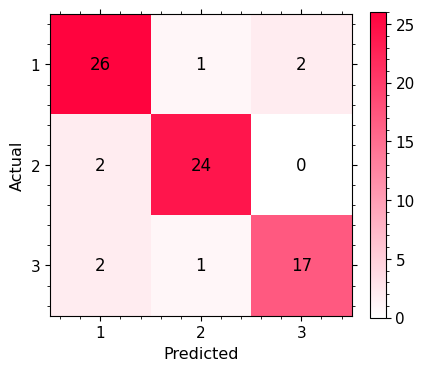

In [14]:
# === AdaBoost Classifier (default parameters) =====================================================

# Initialise AdaBoost Classifier with default parameters
ada = AdaBoostClassifier(random_state=seed_love)

# Train the model on training and validation data
ada.fit(X_train_full, y_train_full)

# Make predictions on test data
y_pred_ada_default = ada.predict(X_test)

# Evaluate the model on test data
accuracy, error, confusion_matrix_result, classification_report_result = evaluate_model(y_test, y_pred_ada_default)

# Print results
print("AdaBoost Classifier (default parameters):\n")
print("Model Accuracy: ", accuracy)
print("Classification Error: ", error)
print("Classification Report:")
print(classification_report_result)

# Plot confusion matrix
print("Confusion Matrix:")
plt.figure(figsize=(4.5, 4))
plt.imshow(confusion_matrix_result, interpolation='nearest', cmap=cmap_red)
plt.colorbar(shrink=0.9)
custom_labels = [1, 2, 3]
tick_marks = np.arange(len(custom_labels))
plt.xticks(tick_marks, custom_labels)
plt.yticks(tick_marks, custom_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
# Add annotations
for i in range(len(confusion_matrix_result)):
    for j in range(len(confusion_matrix_result)):
        plt.text(j, i, str(confusion_matrix_result[i][j]), ha='center', va='center', color='black', fontsize=12)



Optimal number of estimators: 111
Minimum Validation Error: 0.053333333333333344
Maximum Validation Accuracy: 0.9466666666666667


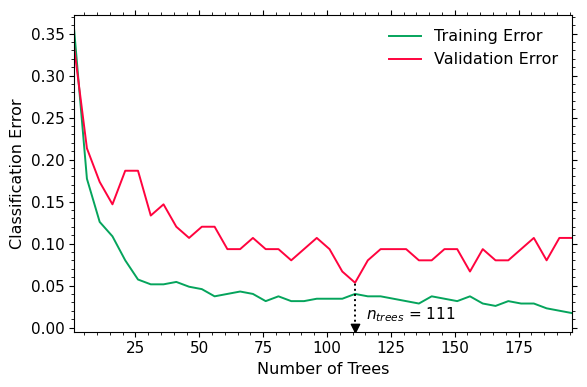

In [15]:
# === AdaBoost Classifier Hyperparameter Tuning ====================================================

# Define hyperparameter search space
n_trees_list = list(range(1, 201, 5))

# Define function to perform hyperparameter tuning
def hyperparameter_tuning_ada(X_train, y_train, X_val, y_val, n_trees_list, seed):
    # Initialise lists to store errors
    train_errors = []
    val_errors = []
    # Loop over different number of estimators
    for n_trees in n_trees_list:
        # Initialise AdaBoost Classifier
        ada_classifier = AdaBoostClassifier(n_estimators=n_trees, random_state=seed)
        ada_classifier.fit(X_train, y_train)
        # Calculate training error
        train_pred = ada_classifier.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_pred)
        train_error = 1 - train_accuracy
        train_errors.append(train_error)
        # Calculate validation error
        val_pred = ada_classifier.predict(X_val)
        val_accuracy = accuracy_score(y_val, val_pred)
        val_error = 1 - val_accuracy
        val_errors.append(val_error)
    return train_errors, val_errors

# Perform hyperparameter tuning
train_errors, val_errors = hyperparameter_tuning_ada(X_train, y_train, X_val, y_val, n_trees_list, seed_love)

# Get the optimal number of estimators and minimum validation error
optimal_n_estimators = n_trees_list[np.argmin(val_errors)]
min_val_error = min(val_errors)
max_val_accuracy = 1 - min_val_error
print("Optimal number of estimators:", optimal_n_estimators)
print("Minimum Validation Error:", min_val_error)
print("Maximum Validation Accuracy:", max_val_accuracy)

# Plot training and validation errors for different hyperparameter values
plt.figure()
plt.plot(n_trees_list, train_errors, linestyle='-', color=sd2022_green, label='Training Error')
plt.plot(n_trees_list, val_errors, linestyle='-', color=sd2022_red, label='Validation Error')
plt.plot([optimal_n_estimators, optimal_n_estimators], [-0.005, min_val_error], linestyle=':', color='black')
plt.scatter(optimal_n_estimators, 0, marker='v', color='black')
plt.text(optimal_n_estimators*1.04, 0.01, '$n_{trees}$ = ' + str(optimal_n_estimators))
plt.xlabel('Number of Trees')
plt.ylabel('Classification Error')
plt.legend()
plt.ylim(bottom=-0.005)
plt.show()


AdaBoost Classifier (optimal parameters):

Model Accuracy:  0.8933333333333333
Classification Error:  0.10666666666666669
Classification Report:
              precision    recall  f1-score   support

           1       0.90      0.90      0.90        29
           2       0.96      0.92      0.94        26
           3       0.81      0.85      0.83        20

    accuracy                           0.89        75
   macro avg       0.89      0.89      0.89        75
weighted avg       0.90      0.89      0.89        75

Confusion Matrix:


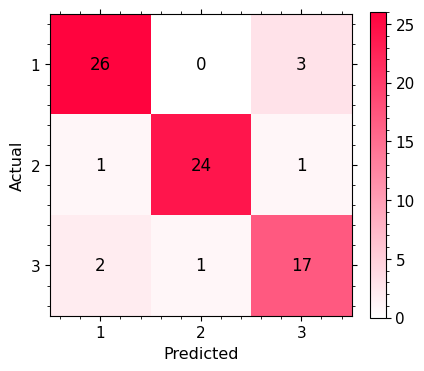

In [16]:
# === AdaBoost Classifier (optimal parameters) =====================================================

# Initialise AdaBoost Classifier with optimal parameters
n_estimators_optimal = 111
ada_opt = AdaBoostClassifier(n_estimators=n_estimators_optimal, random_state=seed_love)

# Train the model on training and validation data
ada_opt.fit(X_train_full, y_train_full)

# Make predictions on test data
y_pred_ada_opt = ada_opt.predict(X_test)

# Evaluate the model on test data
accuracy, error, confusion_matrix_result, classification_report_result = evaluate_model(y_test, y_pred_ada_opt)

# Print results
print("AdaBoost Classifier (optimal parameters):\n")
print("Model Accuracy: ", accuracy)
print("Classification Error: ", error)
print("Classification Report:")
print(classification_report_result)

# Plot confusion matrix
print("Confusion Matrix:")
plt.figure(figsize=(4.5, 4))
plt.imshow(confusion_matrix_result, interpolation='nearest', cmap=cmap_red)
plt.colorbar(shrink=0.9)
custom_labels = [1, 2, 3]
tick_marks = np.arange(len(custom_labels))
plt.xticks(tick_marks, custom_labels)
plt.yticks(tick_marks, custom_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
# Add annotations
for i in range(len(confusion_matrix_result)):
    for j in range(len(confusion_matrix_result)):
        plt.text(j, i, str(confusion_matrix_result[i][j]), ha='center', va='center', color='black', fontsize=12)

Top 67 features based on knee point criterion:
Feature Name      Feature Importance
--------------  --------------------
Fea64                     0.0990991
Fea70                     0.0720721
Fea720                    0.036036
Fea354                    0.027027
Fea674                    0.027027
Fea490                    0.018018
Fea150                    0.018018
Fea361                    0.018018
Fea71                     0.018018
Fea947                    0.018018
Fea162                    0.018018
Fea795                    0.018018
Fea561                    0.018018
Fea60                     0.018018
Fea55                     0.018018
Fea929                    0.018018
Fea199                    0.018018
Fea181                    0.018018
Fea414                    0.018018
Fea702                    0.018018
Fea595                    0.018018
Fea673                    0.018018
Fea210                    0.018018
Fea412                    0.018018
Fea630                    0.018018
Fe

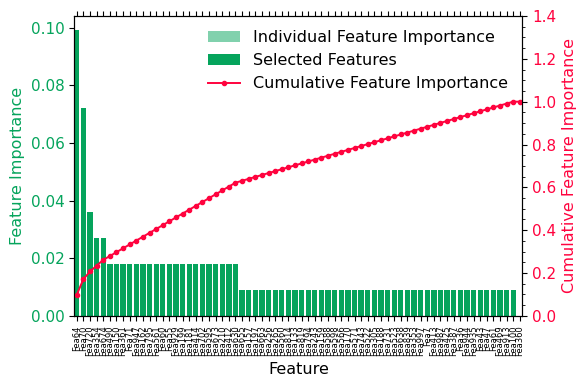

In [17]:
# === AdaBoost Classifier Feature Importance =======================================================

# Get feature importances
feature_importances = ada_opt.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1][:68]
sorted_feature_importance = feature_importances[indices]
sorted_feature_names = X_train_full.columns[indices]
cumulative_importance = np.cumsum(sorted_feature_importance)

# Select the top features based on the knee point in the cumulative error curve
n_features_to_select = find_knee_point(cumulative_importance,knee_criteria=0.00)
top_feature_importance = sorted_feature_importance[:n_features_to_select]
top_feature_names = sorted_feature_names[:n_features_to_select]
top_features_headers = ["Feature Name", "Feature Importance"]
top_features_table = [[name, importance] for name, importance in zip(top_feature_names, top_feature_importance)]
print(f"Top {n_features_to_select} features based on knee point criterion:")
print(tabulate(top_features_table, headers=top_features_headers))

# Plot the feature importances of the forest
fig, ax1 = plt.subplots()
ax1.bar(range(len(sorted_feature_importance)), sorted_feature_importance, color=sd2022_green, alpha = 0.5, label='Individual Feature Importance')
ax1.set_xlabel('Feature')
ax1.set_ylabel('Feature Importance', color=sd2022_green)
ax1.tick_params(axis='y', labelcolor=sd2022_green)
ax1.set_xticks(np.arange(len(sorted_feature_names)))
ax1.set_xticklabels(sorted_feature_names, rotation=90, fontsize=6)
ax1.minorticks_off()

# Plot the cumulative importances
ax2 = ax1.twinx()
ax2.plot(range(len(sorted_feature_importance)), cumulative_importance, color=sd2022_red, marker='.', label='Cumulative Feature Importance')
ax2.set_ylabel('Cumulative Feature Importance', color=sd2022_red)
ax2.tick_params(axis='y', labelcolor=sd2022_red)
ax2.set_ylim(bottom=0.0, top=1.4)

# Plot the chosen number of components
ax1.bar(range(n_features_to_select), top_feature_importance[:n_features_to_select], color= sd2022_green, label='Selected Features')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper right')

plt.show()


Optimal number of estimators: 91
Minimum Validation Error: 0.12
Maximum Validation Accuracy: 0.88


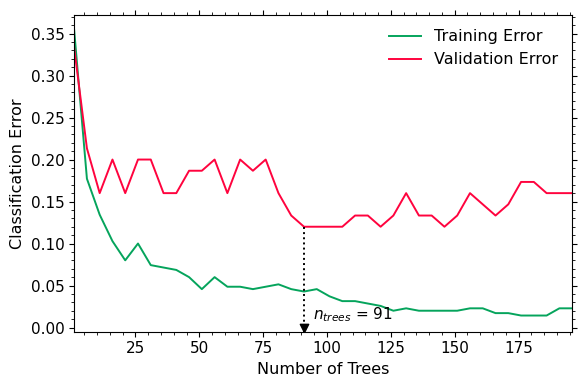

In [18]:
# === AdaBoost Classifier Hyperparameter Tuning (most important features) ==========================

# Get most important features
X_reduced = X[top_feature_names]
X_train_important = X_train[top_feature_names]
X_val_important = X_val[top_feature_names]
X_test_important = X_test[top_feature_names]
X_train_full_important = X_train_full[top_feature_names]

# Define hyperparameter search space
n_estimators_list = list(range(1, 201, 5))

# Perform hyperparameter tuning
train_errors, val_errors = hyperparameter_tuning_ada(X_train_important, y_train, X_val_important, y_val, n_estimators_list, seed_love)

# Get the optimal number of estimators and minimum validation error
optimal_n_estimators = n_estimators_list[np.argmin(val_errors)]
min_val_error = min(val_errors)
max_val_accuracy = 1 - min_val_error
print("Optimal number of estimators:", optimal_n_estimators)
print("Minimum Validation Error:", min_val_error)
print("Maximum Validation Accuracy:", max_val_accuracy)

# Plot training and validation errors for different hyperparameter values
plt.figure()
plt.plot(n_estimators_list, train_errors, linestyle='-', color=sd2022_green, label='Training Error')
plt.plot(n_estimators_list, val_errors, linestyle='-', color=sd2022_red, label='Validation Error')
plt.plot([optimal_n_estimators, optimal_n_estimators], [-0.005, min_val_error], linestyle=':', color='black')
plt.scatter(optimal_n_estimators, 0, marker='v', color='black')
plt.text(optimal_n_estimators*1.04, 0.01, '$n_{trees}$ = ' + str(optimal_n_estimators))
plt.xlabel('Number of Trees')
plt.ylabel('Classification Error')
plt.legend()
plt.ylim(bottom=-0.005)
plt.show()

AdaBoost Classifier (most important features and optimal parameters):

Model Accuracy:  0.9066666666666666
Classification Error:  0.09333333333333338
Classification Report:
              precision    recall  f1-score   support

           1       0.96      0.86      0.91        29
           2       0.96      0.96      0.96        26
           3       0.78      0.90      0.84        20

    accuracy                           0.91        75
   macro avg       0.90      0.91      0.90        75
weighted avg       0.91      0.91      0.91        75

Confusion Matrix:


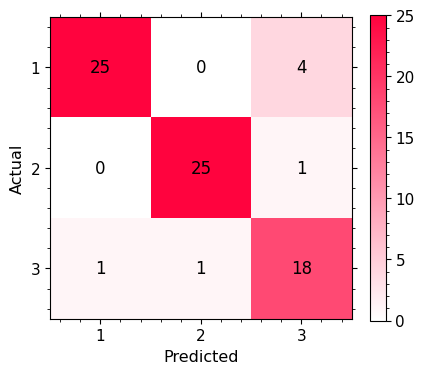

In [19]:
# === AdaBoost Classifier (most important features and optimal parameters) =========================

# Initialise AdaBoost Classifier with optimal parameters
n_trees_optimal = 91
ada_imp = AdaBoostClassifier(n_estimators=n_trees_optimal, random_state=seed_love)

# Train the model on training and validation data
ada_imp.fit(X_train_full_important, y_train_full)

# Make predictions on test data
y_pred_ada_imp = ada_imp.predict(X_test_important)

# Evaluate the model on test data
accuracy, error, confusion_matrix_result, classification_report_result = evaluate_model(y_test, y_pred_ada_imp)

# Print results
print("AdaBoost Classifier (most important features and optimal parameters):\n")
print("Model Accuracy: ", accuracy)
print("Classification Error: ", error)
print("Classification Report:")
print(classification_report_result)

# Plot confusion matrix
print("Confusion Matrix:")
plt.figure(figsize=(4.5, 4))
plt.imshow(confusion_matrix_result, interpolation='nearest', cmap=cmap_red)
plt.colorbar(shrink=0.9)
custom_labels = [1, 2, 3]
tick_marks = np.arange(len(custom_labels))
plt.xticks(tick_marks, custom_labels)
plt.yticks(tick_marks, custom_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
# Add annotations
for i in range(len(confusion_matrix_result)):
    for j in range(len(confusion_matrix_result)):
        plt.text(j, i, str(confusion_matrix_result[i][j]), ha='center', va='center', color='black', fontsize=12)

In [20]:
# === Comparison of Random Forest and AdaBoost Classifiers =========================================

# Default models
print("\n\n=== DEFAULT MODELS =================================================")
print("\nRandom Forest Classifier (default parameters):")
print("Accuracy: ", accuracy_score(y_test, y_pred_rf_default))

print("\nAdaBoost Classifier (default parameters):")
print("Accuracy: ", accuracy_score(y_test, y_pred_ada_default))

print("\nContingeny Table:")
print(pd.crosstab(y_pred_rf_default, y_pred_ada_default, rownames=['Random Forest'], colnames=['AdaBoost']))

# Tuned models
print("\n\n=== TUNED MODELS ===================================================")
print("\nRandom Forest Classifier (optimal parameters):")
print("Accuracy: ", accuracy_score(y_test, y_pred_rf_opt))

print("\nAdaBoost Classifier (optimal parameters):")
print("Accuracy: ", accuracy_score(y_test, y_pred_ada_opt))

print("\nContingeny Table:")
print(pd.crosstab(y_pred_rf_opt, y_pred_ada_opt, rownames=['Random Forest'], colnames=['AdaBoost']))

# Most important feature models
print("\n\n=== MOST IMPORTANT FEATURE MODELS ==================================")
print("\nRandom Forest Classifier (most important features and optimal parameters):")
print("Accuracy: ", accuracy_score(y_test, y_pred_rf_imp))

print("\nAdaBoost Classifier (most important features and optimal parameters):")
print("Accuracy: ", accuracy_score(y_test, y_pred_ada_imp))

print("\nContingeny Table:")
print(pd.crosstab(y_pred_rf_imp, y_pred_ada_imp, rownames=['Random Forest'], colnames=['AdaBoost']))



=== DEFAULT MODELS =================================================

Random Forest Classifier (default parameters):
Accuracy:  0.9333333333333333

AdaBoost Classifier (default parameters):
Accuracy:  0.8933333333333333

Contingeny Table:
AdaBoost        1   2   3
Random Forest            
1              26   1   2
2               2  25   0
3               2   0  17


=== TUNED MODELS ===================================================

Random Forest Classifier (optimal parameters):
Accuracy:  0.9466666666666667

AdaBoost Classifier (optimal parameters):
Accuracy:  0.8933333333333333

Contingeny Table:
AdaBoost        1   2   3
Random Forest            
1              27   0   3
2               1  25   1
3               1   0  17


=== MOST IMPORTANT FEATURE MODELS ==================================

Random Forest Classifier (most important features and optimal parameters):
Accuracy:  0.9466666666666667

AdaBoost Classifier (most important features and optimal parameters):
Accuracy: 